https://medium.com/towards-artificial-intelligence/text-classification-by-xgboost-others-a-case-study-using-bbc-news-articles-5d88e94a9f8

#  Getting the data

In [2]:
import pandas as pd

amazon_text_df = pd.read_csv('minClean_amazon.csv')
amazon_text_df.head()

,Unnamed: 0,Link,Title,Category,Post Author,Leading Comment,Publish Time,Reply Authors,Reply Comments,Reply Times
0,0,http://sellercentral.amazon.com/forums/t/2-box...,2 boxes of books,Fulfillment By Amazon,Earth_Light_Books,I need to know how to start,2020-05-26 17:33:26+00:00,<function get_reply_authors at 0x00000119FBB60...,"['\nI need to know how to start\n', ' \nAmazon...","[Timestamp('2020-05-26 17:48:57+0000', tz='UTC..."
1,1,http://sellercentral.amazon.com/forums/t/fba-s...,FBA Shipment Delivered Delayed Check in,Fulfillment By Amazon,HOUSE_OF_LORDS_RODEO,Hi are there any other seller experiencing del...,2020-05-26 15:28:17+00:00,<function get_reply_authors at 0x00000119FBB60...,['\nHi are there any other seller experiencing...,"[Timestamp('2020-05-26 16:03:50+0000', tz='UTC')]"
2,2,http://sellercentral.amazon.com/forums/t/fba-r...,FBA removal/disposal fees,Fulfillment By Amazon,Texastoys,Hi all\nSo back when the new removaldisposal f...,2020-05-26 05:43:46+00:00,<function get_reply_authors at 0x00000119FBB60...,['\nHi all\nSo back when the new removaldispos...,[]
3,3,http://sellercentral.amazon.com/forums/t/am-i-...,Am i able to send in FBA inventory now?,Fulfillment By Amazon,Assuranceproducts,Im using inventorylab to upload my inventory t...,2020-05-25 16:53:40+00:00,<function get_reply_authors at 0x00000119FBB60...,['\nIm using inventorylab to upload my invento...,"[Timestamp('2020-05-25 17:14:44+0000', tz='UTC..."
4,4,http://sellercentral.amazon.com/forums/t/stran...,Stranded Inventory,Fulfillment By Amazon,BillsBuys,I recently listed 100 books for sale on Amazon...,2020-05-24 02:14:21+00:00,<function get_reply_authors at 0x00000119FBB60...,['\nI recently listed 100 books for sale on Am...,"[Timestamp('2020-05-25 01:42:41+0000', tz='UTC..."


#  Data Exploration & Visualisation

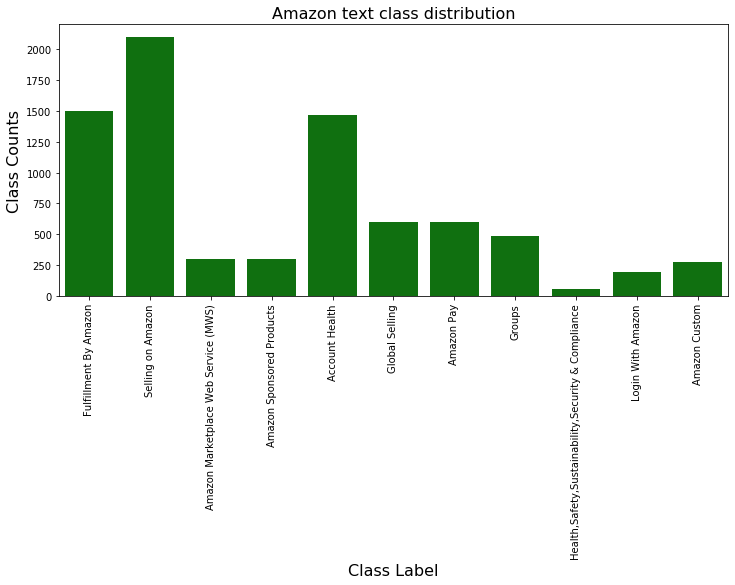

In [3]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.countplot(x=amazon_text_df.Category, color='green')
plt.title('Amazon text class distribution', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical');

In [6]:
amazon_text_df.drop(columns= ['Unnamed: 0', 'Link', 'Publish Time', 'Reply Times', 'Reply Authors'], inplace=True)

In [7]:
df = amazon_text_df.copy()

In [8]:
df['text'] = df['Post Author'] + ' ' + df['Title'] + ' ' + df['Leading Comment'] + ' ' + df['Reply Comments']

In [9]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [10]:
df.iloc[2,1]

'Fulfillment By Amazon'

In [11]:
clean_text(df.iloc[2,1])

'fulfil amazon'

In [12]:
%matplotlib inline

from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

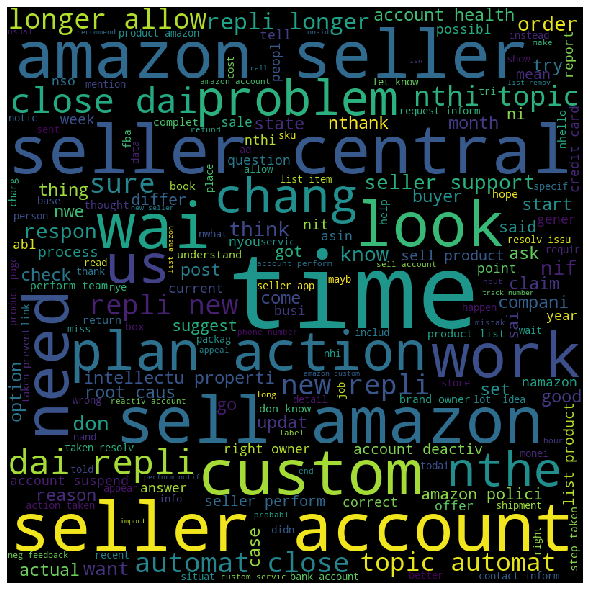

In [13]:
texts = ''
for index, item in df.iterrows():
    texts = texts + ' ' + clean_text(item['text'])
    
plot_word_cloud(texts)

It seems like mostly the posts are about selling, sellers, longer reply, I guess getting advice as well. 

In [19]:
df.rename(columns={"Category": "category"}, inplace=True)

In [20]:
def plot_word_cloud_for_category(df, category):
    text_df = df.loc[df['category'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + clean_text(item['text'])
    
    plot_word_cloud(texts)

In [23]:
df.category.unique()

array(['Fulfillment By Amazon', 'Selling on Amazon',
       'Amazon Marketplace Web Service (MWS)',
       'Amazon Sponsored Products', 'Account Health', 'Global Selling',
       'Amazon Pay', 'Groups',
       'Health,Safety,Sustainability,Security & Compliance',
       'Login With Amazon', 'Amazon Custom'], dtype=object)

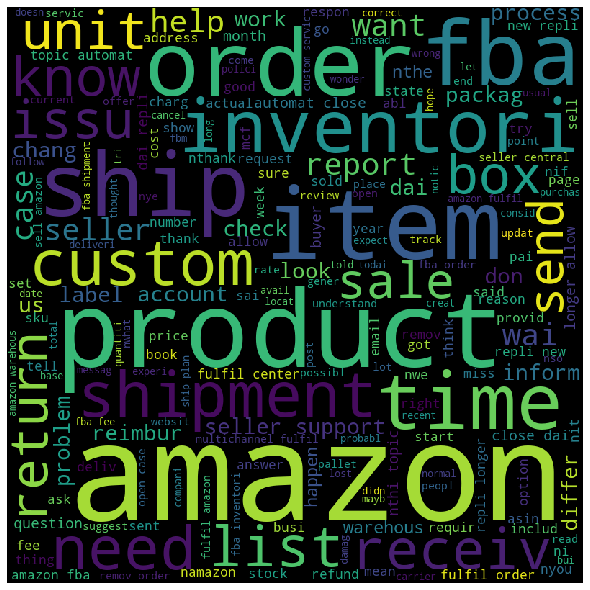

In [24]:
plot_word_cloud_for_category(df,'Fulfillment By Amazon')

**Fulfillment By Amazon**: order, shipment, time. I guess this is mostly about reviews either time taken to receive the product or the state of the product itself.

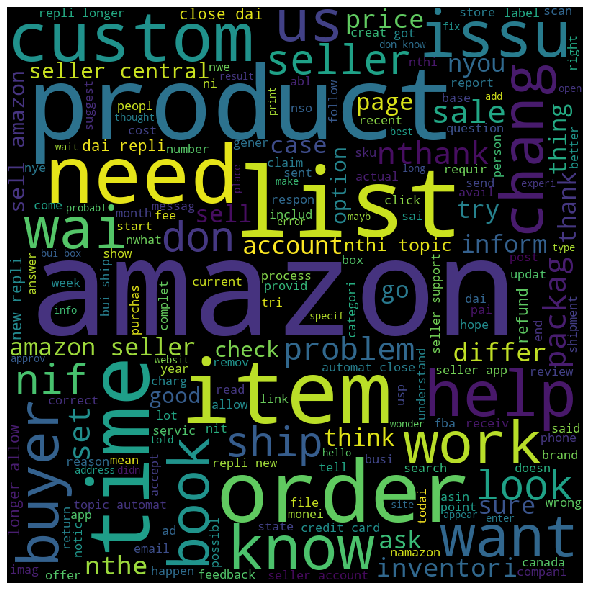

In [26]:
plot_word_cloud_for_category(df,'Selling on Amazon')

**Selling on Amazon**: I guess it's about asking for help about selling in amazon and asking about other peoples experience or results (sale).

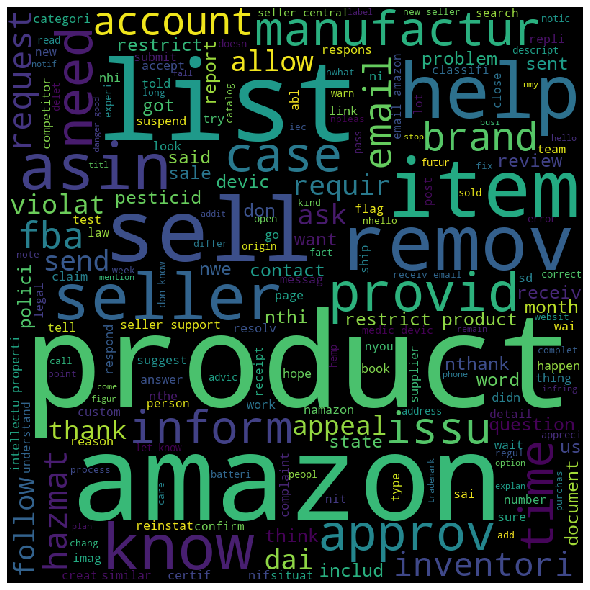

In [28]:
plot_word_cloud_for_category(df,'Health,Safety,Sustainability,Security & Compliance')

There are several words common between the categories (normal) which are : product, amazon, issu, item, help.
It would be intersting to investigate how much times they appear (perhaps get ride of them and see if accuracy is going to improve?).

In [29]:
df_x = df['text']
df_y = df['category']

# Building the Machine Learning model & pipeline

## Converting to Doc2Vec

In [30]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))

In [31]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)
doc2vec_features

100%|██████████| 7882/7882 [00:00<00:00, 1675595.75it/s]


matrix([[-0.00277872, -0.00501187,  0.00482856, ..., -0.0008983 ,
          0.00663877, -0.00025027],
        [ 0.00234055, -0.00532782,  0.00668937, ..., -0.00276364,
          0.00571931,  0.00571155],
        [ 0.00426091, -0.00314035, -0.0013386 , ...,  0.00154023,
         -0.00435641,  0.00448706],
        ...,
        [ 0.02304544,  0.1583538 , -0.05634788, ...,  0.05963844,
         -0.1528518 , -0.06593791],
        [-0.0044461 , -0.00192232,  0.00569911, ..., -0.00424831,
          0.00223549, -0.0003378 ],
        [-0.00429653, -0.00084236,  0.00440887, ..., -0.00040945,
          0.00469861, -0.00300767]], dtype=float32)

## Pipeline with Doc2Vec & LogisticRegression

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

100%|██████████| 6303/6303 [00:00<00:00, 1379210.04it/s]
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 6304/6304 [00:00<00:00, 1688650.68it/s]
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 6306/6306 [00:00<00:00, 2532728.24it/s]
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 6307/6307 [00:00<00:00, 2717357.51it/s]
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/linear_mo

Accuracy for Logistic Regression:  0.2959826923098424


## Pipeline with Doc2Vec & RandomForest

In [33]:
from sklearn.ensemble import RandomForestClassifier

pl_random_forest = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

100%|██████████| 6303/6303 [00:00<00:00, 2495205.11it/s]
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 6304/6304 [00:00<00:00, 1454794.63it/s]
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 6306/6306 [00:00<00:00, 2222815.45it/s]
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 6307/6307 [00:00<00:00, 2839574.42it/s]
/opt/anaconda3/envs/de

Accuracy for RandomForest :  0.22430165617671932


## Pipeline with Doc2Vec & XGBoost

In [34]:
import xgboost as xgb

pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

100%|██████████| 6308/6308 [00:00<00:00, 2506173.12it/s]


Accuracy for XGBoost Classifier :  0.26959275571562236


## Converting to Tf-Idf

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [36]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [37]:
tfidf_vectors.shape

(7882, 43292)

In [38]:
print(tfidf_vectors)

  (0, 42852)	0.10716138942692059
  (0, 42833)	0.16291259128557395
  (0, 42365)	0.1374588226926075
  (0, 42353)	0.06082974395699173
  (0, 42348)	0.044435190334657586
  (0, 42294)	0.042336825128041385
  (0, 42287)	0.011432118887967885
  (0, 42172)	0.15682012940168905
  (0, 42078)	0.04504563919250176
  (0, 41932)	0.08467365025608277
  (0, 41913)	0.036371471933238524
  (0, 41874)	0.020424454389634677
  (0, 40770)	0.026833295365657914
  (0, 40575)	0.020288743969423657
  (0, 40373)	0.044435190334657586
  (0, 39668)	0.04592400414213082
  (0, 39436)	0.04153906370133075
  (0, 39105)	0.5237110079112914
  (0, 39013)	0.04802236934874703
  (0, 38906)	0.019217029254805996
  (0, 38810)	0.039199947859783306
  (0, 38712)	0.028741140700716133
  (0, 38670)	0.01968054574204271
  (0, 38578)	0.02912946319827759
  (0, 38528)	0.12839240829816084
  :	:
  (7881, 29239)	0.21975827873827963
  (7881, 29192)	0.11730330184873854
  (7881, 29084)	0.11653154836178616
  (7881, 29059)	0.03703631468681082
  (7881, 29030)	

## Pipeline with Tf-Idf & LogisticRegression

In [39]:
pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                    ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

Accuracy for Tf-Idf & Logistic Regression:  0.6136588119830015


## Pipeline with Tf-Idf & RandomForest

In [40]:
pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                          ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & RandomForest : ', scores.mean())

/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for Tf-Idf & RandomForest :  0.48855797090863673


## Pipeline with Tf-Idf & XGBoost

In [ ]:
pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())